## Library Imports

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, split, explode,substring, length
from pyspark.sql.types import DecimalType, StringType, DoubleType
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Session starting

In [5]:
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

## Loading Data

In [6]:
# spark is an custom SparkSession based on some config to work with Jupyter notebooks
iv = spark.read.csv("hdfs://localhost:9000/user/lavish/data/investments.csv"
                , header='true'
                , inferSchema='true')

## Defining the analysis Scope

In [7]:
startYear=1995
endYear=2015

## Checking the schema details

In [8]:
iv.schema.names

['company_permalink',
 'company_name',
 'company_category_list',
 'company_country_code',
 'company_state_code',
 'company_region',
 'company_city',
 'investor_permalink',
 'investor_name',
 'investor_country_code',
 'investor_state_code',
 'investor_region',
 'investor_city',
 'funding_round_permalink',
 'funding_round_type',
 'funding_round_code',
 'funded_at',
 'raised_amount_usd']

In [9]:
filteredIV = iv.filter(iv.raised_amount_usd.isNotNull()).dropDuplicates()
filteredIV.select('raised_amount_usd', 'funded_at','company_category_list').filter(filteredIV.company_category_list.contains('|')).show(5, truncate = False)

+-----------------+----------+---------------------------------------------------------------------------------------------------------------------------+
|raised_amount_usd|funded_at |company_category_list                                                                                                      |
+-----------------+----------+---------------------------------------------------------------------------------------------------------------------------+
|321650.0         |20-06-2013|Curated Web|Education|Parenting|Publishing                                                                                 |
|9000000.0        |13-11-2006|Cloud Computing|Communications Hardware|Hardware|Networking|Optimization|Security|SEO|Technology|Virtualization|Web Hosting|
|8000000.0        |06-12-2002|Application Platforms|Communications Infrastructure|Storage                                                                |
|1.2E7            |04-01-2012|Enterprise Software|Security            

In [10]:
splittedCategoryIV = filteredIV.select('raised_amount_usd',  substring('funded_at',-4,4).cast('int').alias('year')
                       , split(col("company_category_list")
                       , "[|]s*").alias("categoryArr")).filter(col('year') >= startYear)
splittedCategoryIV.show(5, truncate = False)

+-----------------+----+--------------------------------------------------------------------------------------------------------------------------------------+
|raised_amount_usd|year|categoryArr                                                                                                                           |
+-----------------+----+--------------------------------------------------------------------------------------------------------------------------------------+
|321650.0         |2013|[Curated Web, Education, Parenting, Publishing]                                                                                       |
|1019139.0        |2013|[Web Hosting]                                                                                                                         |
|3134880.0        |2012|[Finance]                                                                                                                             |
|9000000.0        |2006|[Cloud Computing

In [11]:
explodedIV=splittedCategoryIV.select('raised_amount_usd','year', explode('categoryArr').alias('category'))

In [12]:
explodedIV.show(5)

+-----------------+----+-----------+
|raised_amount_usd|year|   category|
+-----------------+----+-----------+
|         321650.0|2013|Curated Web|
|         321650.0|2013|  Education|
|         321650.0|2013|  Parenting|
|         321650.0|2013| Publishing|
|        1019139.0|2013|Web Hosting|
+-----------------+----+-----------+
only showing top 5 rows



In [13]:
explodedIV.write.mode("overwrite").saveAsTable("investments")

AnalysisException: org.apache.hadoop.hive.ql.metadata.HiveException: java.lang.RuntimeException: Unable to instantiate org.apache.hadoop.hive.ql.metadata.SessionHiveMetaStoreClient;

In [14]:
sqlDF = spark.sql("SELECT * FROM investments")
sqlDF.show(5)

+-----------------+----+---------------+
|raised_amount_usd|year|       category|
+-----------------+----+---------------+
|            1.5E7|2014|     E-Commerce|
|            1.4E7|2015|         Drones|
|            1.4E7|2015|  Manufacturing|
|        1870000.0|2011|             3D|
|        1870000.0|2011|Computer Vision|
+-----------------+----+---------------+
only showing top 5 rows



### Year Wise

In [15]:
SQLQUERY =  """
            SELECT CATEGORY, 
            CAST(YEAR AS INT), 
            SUM(RAISED_AMOUNT_USD) AS TOTAL, 
            CAST(SUM(RAISED_AMOUNT_USD) AS DECIMAL(30)) AS TOTAL_DEC 
            FROM INVESTMENTS 
            GROUP BY CATEGORY, YEAR
            ORDER BY CATEGORY,YEAR
            """
#  ORDER BY YEAR DESC, TOTAL DESC

In [16]:
sqlDF = spark.sql(SQLQUERY)
sqlDF.show(5)

+--------+----+------------+---------+
|CATEGORY|YEAR|       TOTAL|TOTAL_DEC|
+--------+----+------------+---------+
|      3D|2003|      3.64E8|364000000|
|      3D|2005|   1129590.0|  1129590|
|      3D|2006|   4.20152E7| 42015200|
|      3D|2007| 1.0037656E8|100376560|
|      3D|2008|1.67802633E8|167802633|
+--------+----+------------+---------+
only showing top 5 rows



### Total

In [17]:
SQLQUERY =  """
            SELECT CATEGORY, SUM(RAISED_AMOUNT_USD) AS TOTAL, 
            CAST(SUM(RAISED_AMOUNT_USD) AS DECIMAL(30)) AS TOTAL_DEC 
            FROM INVESTMENTS GROUP 
            BY CATEGORY
            ORDER BY TOTAL DESC
            LIMIT 8
            """


In [18]:
sqlDFtop = spark.sql(SQLQUERY)
sqlDFtop.show(8, truncate = False)
categories = sqlDFtop.select('CATEGORY')

+-------------------+---------------------+------------+
|CATEGORY           |TOTAL                |TOTAL_DEC   |
+-------------------+---------------------+------------+
|Biotechnology      |3.0047395208808673E11|300473952088|
|Software           |2.5418940718297742E11|254189407183|
|E-Commerce         |2.0122358863163824E11|201223588632|
|Mobile             |1.8763575923026706E11|187635759230|
|Enterprise Software|1.4492127042893082E11|144921270429|
|Health Care        |1.3781219049487314E11|137812190495|
|Internet           |1.118099593513909E11 |111809959351|
|Clean Technology   |1.0597931900403362E11|105979319004|
+-------------------+---------------------+------------+



In [19]:
topCategories = [row.CATEGORY for row in categories.collect()]
topCategories

['Biotechnology',
 'Software',
 'E-Commerce',
 'Mobile',
 'Enterprise Software',
 'Health Care',
 'Internet',
 'Clean Technology']

In [26]:
topCategoriesDF = sqlDF.filter(col('CATEGORY').isin(topCategories))

In [40]:
dict = {}

for row in topCategoriesDF.collect():
    
    if (row.CATEGORY in dict ):
        dict[row.CATEGORY]['Y'].append(row.YEAR)
        dict[row.CATEGORY]['T'].append(row.TOTAL_DEC/1000000)
    else:
        dict[row.CATEGORY] = { 'Y': [row.YEAR]  , 'T':[row.TOTAL_DEC/1000000]}
   

In [41]:
dict

{'Biotechnology': {'Y': [1998,
   1999,
   2000,
   2001,
   2002,
   2003,
   2004,
   2005,
   2006,
   2007,
   2008,
   2009,
   2010,
   2011,
   2012,
   2013,
   2014,
   2015],
  'T': [Decimal('4.8'),
   Decimal('45.40874'),
   Decimal('689.871822'),
   Decimal('1335.255496'),
   Decimal('3730.721055'),
   Decimal('8198.870182'),
   Decimal('16082.322549'),
   Decimal('11634.854335'),
   Decimal('15925.340477'),
   Decimal('30340.54939'),
   Decimal('16095.351971'),
   Decimal('22825.073128'),
   Decimal('23260.647687'),
   Decimal('20653.634246'),
   Decimal('22034.623733'),
   Decimal('25633.097745'),
   Decimal('33711.719252'),
   Decimal('48271.81028')]},
 'Clean Technology': {'Y': [2000,
   2001,
   2002,
   2003,
   2004,
   2005,
   2006,
   2007,
   2008,
   2009,
   2010,
   2011,
   2012,
   2013,
   2014,
   2015],
  'T': [Decimal('360'),
   Decimal('62'),
   Decimal('194.2'),
   Decimal('22.087939'),
   Decimal('536.904614'),
   Decimal('832.2825'),
   Decimal('3046

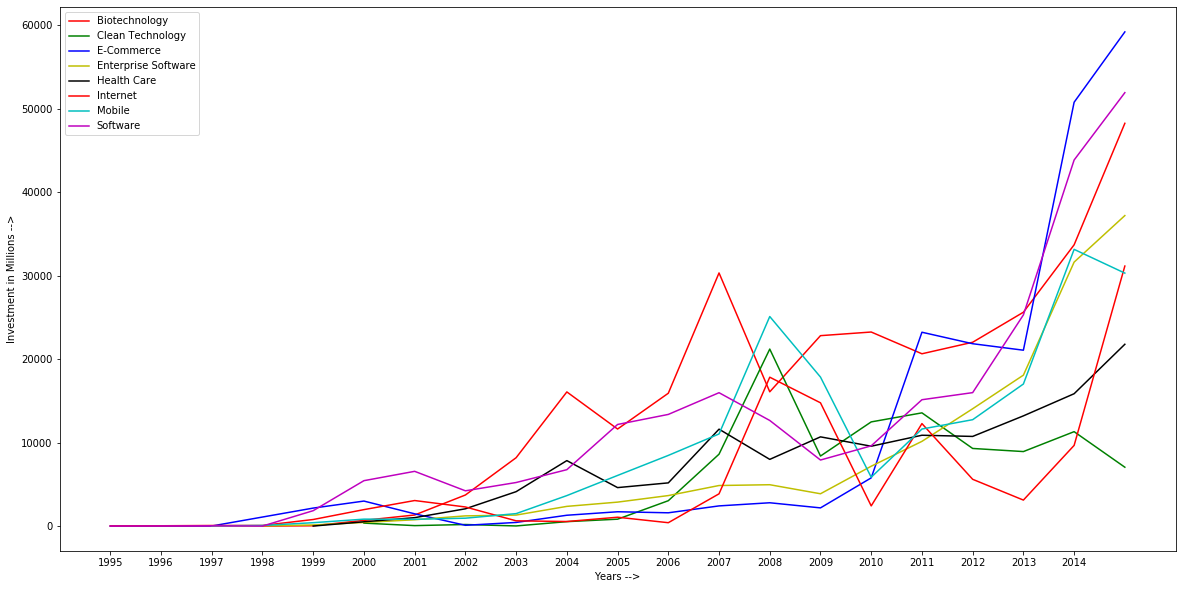

In [44]:
color=cycle('rgbykrcm')
plt.figure(figsize=(20,10))

for cat,c in zip(dict,color):
    #print (cat, c)
    plt.plot(dict[cat]['Y'], dict[cat]['T'], c = c, label = cat)

plt.ylabel('Investment in Millions -->')  
plt.xlabel('Years -->')  
plt.legend()
plt.xticks(np.arange(1995, 2015, 1.0))
plt.savefig('topCategories.png' , pi=300, quality =95 )
plt.show()